<a href="https://colab.research.google.com/github/adspacheco/classificacao-fraturas/blob/main/analises_classificacao_fraturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtenção dos Dados

In [1]:
%%capture
!wget https://github.com/adspacheco/classificacao-fraturas/raw/main/dataset/dataset.zip
!unzip /content/dataset.zip

# Bibliotecas e Constantes


In [2]:
%%capture
!wget https://raw.githubusercontent.com/adspacheco/classificacao-fraturas/main/utils.py

In [3]:
import utils
import glob
import pandas as pd
import time
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [4]:
BASE_PATH = '/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x'

# Exploração da Estrutura dos Arquivos

In [5]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

'Avulsion fracture'	'Greenstick fracture'  'Longitudinal fracture'	'Spiral Fracture'
'Comminuted fracture'	'Hairline Fracture'    'Oblique fracture'
'Fracture Dislocation'	'Impacted fracture'    'Pathological fracture'


Cada tipo de fratura possui um diretório único.

In [6]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture

Test  Train


O tipo de fratura "Avulsion fracture" tem uma pasta test/train associada.

In [7]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture/Test

000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg
05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a3e1e25a0cac6f45.jpg
1b62e6fbfbc5a2f70c6af413189cfc82_jpg.rf.2761e933cc6d206308877cccaf0642b2.jpg
1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg
220px-Avulsion_fracture_of_tibial_tuberosity2C_annotated_jpg.rf.aac7ac1f6ad2f7a822ee729f39b750af.jpg
31446tn_jpg.rf.fd1466bd9c9a7d604dc3e782f87b84d6.jpg
389382_jpg.rf.8cb98ee798766a2d3f6a76279ba5d0d9.jpg
5c7fec45769db28bdd107336f19004336689a4fb804b37af3096741f2879ff02_jumbo_jpeg.rf.68a4d14a09ed5baf1f8e1c1957ee5a01.jpg
60683ca7a8a5848feda86d15_acl-avulsion-fracture-1_jpg.rf.17e17d797643e92164cc9825dc530399.jpg
9896089d1b31b0ba0158dc33122899_jumbo_jpeg.rf.d5e6b871460129728d2506e55476d496.jpg
9dcddacffaff8689cc1e9cedbe76a5_jumbo_jpeg.rf.7259a238161cf03dca23a3dd5369e0b1.jpg
avuls

Dentro do diretório Test do tipo de fratura "Avulsion fracture" tem o arquivo da imagem, todas com extensão .jpg

# Validação da Estrutura dos Arquivos
- Toda pasta (tipo de fratura) tem train/test associada
- Todos arquivos (imagens das fraturas) são .jpg
- Visualização dos arquivos se é de fato imagem de fraturas

Todos os diretórios possuem 'Train' e 'Test', e todos os arquivos são .jpg, alguns arquivos de exemplo:

Exemplos de arquivos:
/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Fracture Dislocation/Train/images11_jpg.rf.f49a62d108ce15babe1c6f07cdb6ff41.jpg


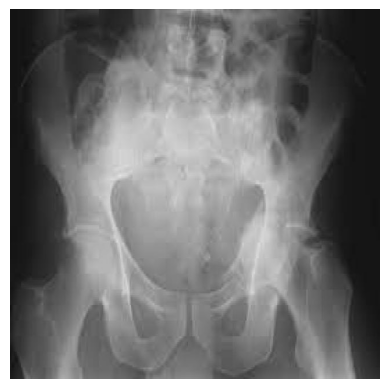

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Comminuted fracture/Train/10d41db0c5b211ecaf8f3b25e15igure-1-ab_png.rf.2b8f2e1fb03a549c1255a9d94aa8f7d8.jpg


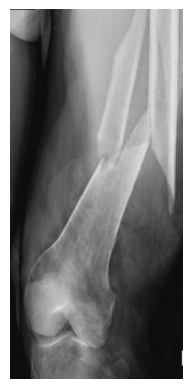

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Greenstick fracture/Train/image13_jpeg.rf.bf7370768c21919fbc560e56fe7770ff.jpg


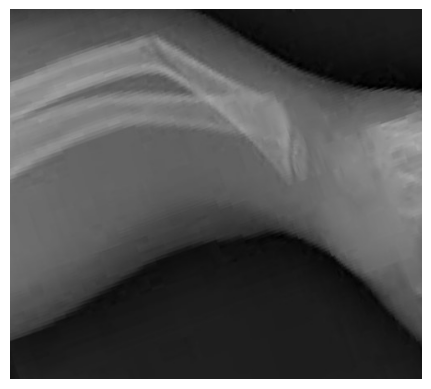

In [8]:
utils.validate_and_list_files(BASE_PATH)

# Quantidade de arquivos

In [9]:
initial_counts = utils.count_files_and_calculate_percentages(BASE_PATH)

Diretório: Spiral Fracture - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)
Diretório: Hairline Fracture - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)
Diretório: Greenstick fracture - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: Longitudinal fracture - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: Fracture Dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: Oblique fracture - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)
Diretório: Impacted fracture - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: Avulsion fracture - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)
Diretório: Pathological fracture - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: Comminuted fracture - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)

Resumo:
  Total Train: 989 (87.60%)
  

# Padronização dos Arquivos

In [10]:
old_to_new_dir_names = utils.rename_directories_and_files(BASE_PATH)

print("\nContagem de arquivos depois da padronização:")

new_counts = utils.count_files_and_calculate_percentages(BASE_PATH, train_name='train', test_name='test')

utils.validate_counts(initial_counts, new_counts, old_to_new_dir_names)


Contagem de arquivos depois da padronização:
Diretório: oblique - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)
Diretório: hairline - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)
Diretório: impacted - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: spiral - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)
Diretório: comminuted - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)
Diretório: fracture_dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: longitudinal - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: pathological - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: greenstick - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: avulsion - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)

Resumo:
  Total Train: 989 (87.60%)
  Total Test: 140 (12.40%)

Padroniza

In [11]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

avulsion    fracture_dislocation  hairline  longitudinal  pathological
comminuted  greenstick		  impacted  oblique	  spiral


In [12]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion

test  train


In [13]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion/test

avulsion_110.jpg  avulsion_113.jpg  avulsion_116.jpg  avulsion_119.jpg	avulsion_122.jpg
avulsion_111.jpg  avulsion_114.jpg  avulsion_117.jpg  avulsion_120.jpg	avulsion_123.jpg
avulsion_112.jpg  avulsion_115.jpg  avulsion_118.jpg  avulsion_121.jpg


# Criação do Dataframe

In [14]:
image_files = glob.glob(f'{BASE_PATH}/**/*.jpg', recursive=True)

In [15]:
df = pd.DataFrame(image_files, columns=['full_path'])
df.head()

,full_path
0,/content/classificacao-imagem-tipos-fraturas-o...
1,/content/classificacao-imagem-tipos-fraturas-o...
2,/content/classificacao-imagem-tipos-fraturas-o...
3,/content/classificacao-imagem-tipos-fraturas-o...
4,/content/classificacao-imagem-tipos-fraturas-o...


In [16]:
aux = df.iloc[0]['full_path']
aux = aux.split('/')
aux

['',
 'content',
 'classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x',
 'oblique',
 'train',
 'oblique_007.jpg']

In [17]:
df['type_dataset'] = df.full_path.apply(lambda x: x.split('/')[-2])
df['target'] = df.full_path.apply(lambda x: x.split('/')[-3])
df['filename'] = df.full_path.apply(lambda x: x.split('/')[-1])

In [18]:
df.sample(5)

,full_path,type_dataset,target,filename
850,/content/classificacao-imagem-tipos-fraturas-o...,train,pathological,pathological_068.jpg
1022,/content/classificacao-imagem-tipos-fraturas-o...,train,avulsion,avulsion_096.jpg
1043,/content/classificacao-imagem-tipos-fraturas-o...,train,avulsion,avulsion_035.jpg
894,/content/classificacao-imagem-tipos-fraturas-o...,train,greenstick,greenstick_058.jpg
926,/content/classificacao-imagem-tipos-fraturas-o...,train,greenstick,greenstick_098.jpg


In [19]:
df.type_dataset.value_counts(1)

type_dataset
train    0.875996
test     0.124004
Name: proportion, dtype: float64

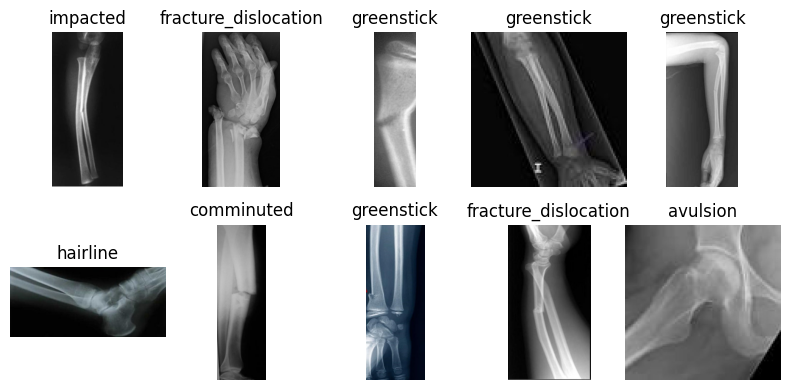

In [20]:
utils.plot_random_imgs(df)

1. Converter Array
2. Resize
3. Normalizar

In [21]:
new_imgs_size = (32, 32)

imgs_train, targets_train, imgs_test, targets_test = utils.process_images(df, new_imgs_size)

# Verificar se as imagens foram processadas corretamente
print(f"Número de imagens de treino: {len(imgs_train)}, Número de imagens de teste: {len(imgs_test)}")

Número de imagens de treino: 989, Número de imagens de teste: 140


In [22]:
X_train = np.array(imgs_train)
y_train = np.array(targets_train)

X_test = np.array(imgs_test)
y_test = np.array(targets_test)

In [23]:
X_train.shape, X_test.shape

((989, 32, 32, 3), (140, 32, 32, 3))

In [25]:
# linhas, altura, largura, canais

In [24]:
y_train.shape, y_test.shape

((989,), (140,))

In [26]:
#new_path = "/content/dataset-serializado"

#!mkdir -p /content/dataset-serializado - dps alterar para o Drive

#save_obj(X_train, f'{new_path}/X_train.joblib')
#save_obj(X_test, f'{new_path}/X_test.joblib')
#save_obj(y_train, f'{new_path}/y_train.joblib')
#save_obj(y_test, f'{new_path}/y_test.joblib')

In [27]:
le = LabelEncoder()

y_train_encoder = le.fit_transform(y_train)
y_test_encoder = le.transform(y_test)

In [28]:
# Quantidade de Categorias
num_classes = 10

y_train_categorical = to_categorical(y_train_encoder, num_classes)
y_test_categorical = to_categorical(y_test_encoder, num_classes)

In [29]:
X_train.shape

(989, 32, 32, 3)

# CNN

In [30]:
input_shape = X_train[0].shape
input_shape

(32, 32, 3)

In [31]:
num_classes = y_train_categorical.shape[1]
num_classes

10

In [32]:
model = Sequential()

model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape
))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [34]:
historico = model.fit(
    X_train,
    y_train_categorical,
    batch_size=128,
    epochs=500,
    verbose=1,
    validation_data=(X_test, y_test_categorical)
)

Epoch 1/500
8/8 [==============================] - 6s 638ms/step - loss: 2.2953 - accuracy: 0.1132 - val_loss: 2.3009 - val_accuracy: 0.0786
Epoch 2/500
8/8 [==============================] - 5s 577ms/step - loss: 2.2830 - accuracy: 0.1325 - val_loss: 2.2957 - val_accuracy: 0.0857
Epoch 3/500
8/8 [==============================] - 5s 662ms/step - loss: 2.2729 - accuracy: 0.1395 - val_loss: 2.2924 - val_accuracy: 0.0786
Epoch 4/500
8/8 [==============================] - 3s 362ms/step - loss: 2.2660 - accuracy: 0.1335 - val_loss: 2.2904 - val_accuracy: 0.1286
Epoch 5/500
8/8 [==============================] - 3s 379ms/step - loss: 2.2593 - accuracy: 0.1557 - val_loss: 2.2904 - val_accuracy: 0.1357
Epoch 6/500
8/8 [==============================] - 3s 360ms/step - loss: 2.2540 - accuracy: 0.1648 - val_loss: 2.2901 - val_accuracy: 0.1357
Epoch 7/500
8/8 [==============================] - 4s 543ms/step - loss: 2.2495 - accuracy: 0.1689 - val_loss: 2.2892 - val_accuracy: 0.1500
Epoch 8/500
8

In [37]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history['loss'], 'r-', label='train loss')
    ax1.plot(history.history['val_loss'], 'b--', label='test loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax1.legend()

    ax2.plot(history.history['accuracy'], 'r-', label='train acc')
    ax2.plot(history.history['val_accuracy'], 'b--', label='test acc')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()

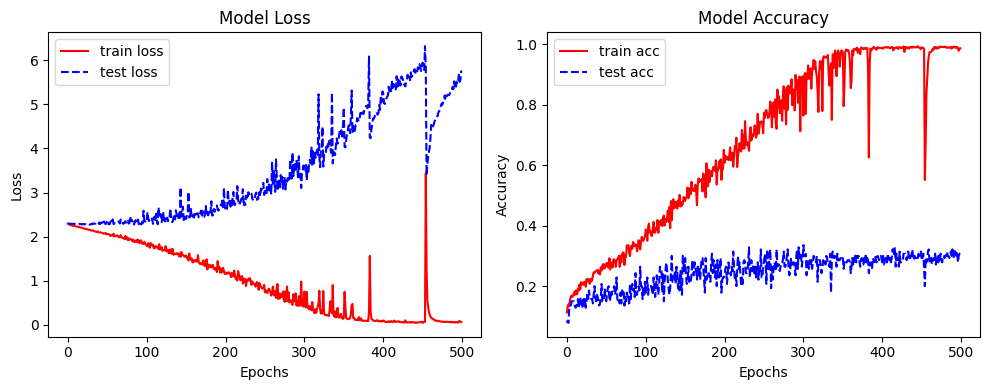

In [38]:
plot_history(historico)

In [39]:
model.evaluate(X_test, y_test_categorical)

5/5 [==============================] - 0s 57ms/step - loss: 5.7696 - accuracy: 0.3071


[5.769637107849121, 0.30714285373687744]

In [40]:
predictions = model.predict(X_test)
predictions

5/5 [==============================] - 0s 41ms/step


array([[9.2292175e-04, 5.9240457e-04, 5.3023332e-04, ..., 1.5738070e-01,
        5.1818071e-03, 2.6794463e-02],
       [1.8776673e-01, 6.9994920e-01, 2.9469886e-06, ..., 4.0497359e-02,
        8.1194514e-05, 1.7796410e-07],
       [4.9216859e-03, 4.2207903e-06, 9.7128648e-01, ..., 1.8512450e-05,
        4.8884613e-06, 4.4371828e-04],
       ...,
       [1.9251086e-02, 2.3176962e-01, 3.7200856e-03, ..., 3.0908657e-03,
        2.0882899e-04, 1.5859405e-05],
       [2.0154610e-02, 2.2062419e-02, 4.0159631e-01, ..., 6.9059437e-04,
        2.4096399e-04, 8.5283566e-04],
       [2.0614692e-05, 2.5549787e-04, 5.2180747e-04, ..., 2.8925040e-04,
        1.5087059e-03, 5.2377905e-05]], dtype=float32)

In [41]:
predictions[0]

array([9.2292175e-04, 5.9240457e-04, 5.3023332e-04, 6.1868215e-01,
       8.8050969e-02, 8.8746086e-02, 1.3118270e-02, 1.5738070e-01,
       5.1818071e-03, 2.6794463e-02], dtype=float32)

In [42]:
np.argmax(predictions, axis=1)

array([3, 1, 2, 3, 6, 6, 0, 4, 2, 3, 7, 3, 3, 0, 7, 0, 0, 8, 1, 2, 6, 3,
       7, 5, 5, 0, 3, 0, 8, 8, 8, 2, 8, 0, 2, 3, 3, 1, 3, 9, 6, 6, 6, 3,
       3, 0, 7, 8, 2, 1, 1, 8, 1, 1, 2, 2, 1, 6, 6, 1, 1, 2, 4, 3, 2, 2,
       2, 2, 2, 0, 3, 2, 4, 0, 6, 3, 2, 2, 0, 4, 6, 2, 1, 0, 3, 6, 0, 5,
       5, 2, 3, 6, 8, 0, 3, 8, 4, 1, 8, 4, 2, 8, 4, 6, 8, 8, 1, 1, 7, 3,
       1, 3, 3, 3, 2, 3, 3, 3, 8, 1, 4, 3, 0, 3, 3, 4, 0, 8, 6, 0, 0, 0,
       9, 1, 0, 3, 0, 6, 3, 6])

In [43]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes[:10]

array([3, 1, 2, 3, 6, 6, 0, 4, 2, 3])

In [44]:
le.inverse_transform(predicted_classes)[:10]

array(['greenstick', 'comminuted', 'fracture_dislocation', 'greenstick',
       'longitudinal', 'longitudinal', 'avulsion', 'hairline',
       'fracture_dislocation', 'greenstick'], dtype='<U20')

In [45]:
df_test = df[df['type_dataset'] == 'test'].copy()
df_test['predicted_class'] = le.inverse_transform(predicted_classes)

In [46]:
df_test['predicted_class_proba'] = np.max(predictions, axis=1)

In [47]:
df_test

,full_path,type_dataset,target,filename,img_processada,predicted_class,predicted_class_proba
69,/content/classificacao-imagem-tipos-fraturas-o...,test,oblique,oblique_084.jpg,True,greenstick,0.618682
70,/content/classificacao-imagem-tipos-fraturas-o...,test,oblique,oblique_082.jpg,True,comminuted,0.699949
71,/content/classificacao-imagem-tipos-fraturas-o...,test,oblique,oblique_085.jpg,True,fracture_dislocation,0.971286
72,/content/classificacao-imagem-tipos-fraturas-o...,test,oblique,oblique_077.jpg,True,greenstick,0.999997
73,/content/classificacao-imagem-tipos-fraturas-o...,test,oblique,oblique_081.jpg,True,longitudinal,0.439564
...,...,...,...,...,...,...,...
1124,/content/classificacao-imagem-tipos-fraturas-o...,test,avulsion,avulsion_120.jpg,True,greenstick,0.386624
1125,/content/classificacao-imagem-tipos-fraturas-o...,test,avulsion,avulsion_112.jpg,True,avulsion,0.775821
1126,/content/classificacao-imagem-tipos-fraturas-o...,test,avulsion,avulsion_111.jpg,True,longitudinal,0.704071
1127,/content/classificacao-imagem-tipos-fraturas-o...,test,avulsion,avulsion_118.jpg,True,greenstick,0.462360


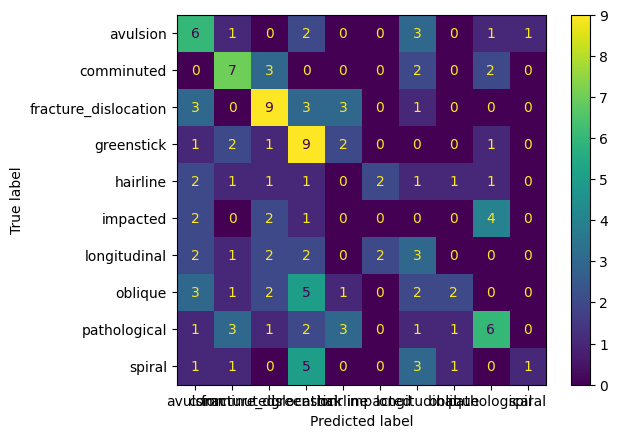

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(df_test['target'], df_test['predicted_class'])

In [51]:
df_test.shape

(140, 7)

In [52]:
df_diff = df_test[df_test['target'] != df_test['predicted_class']].copy()

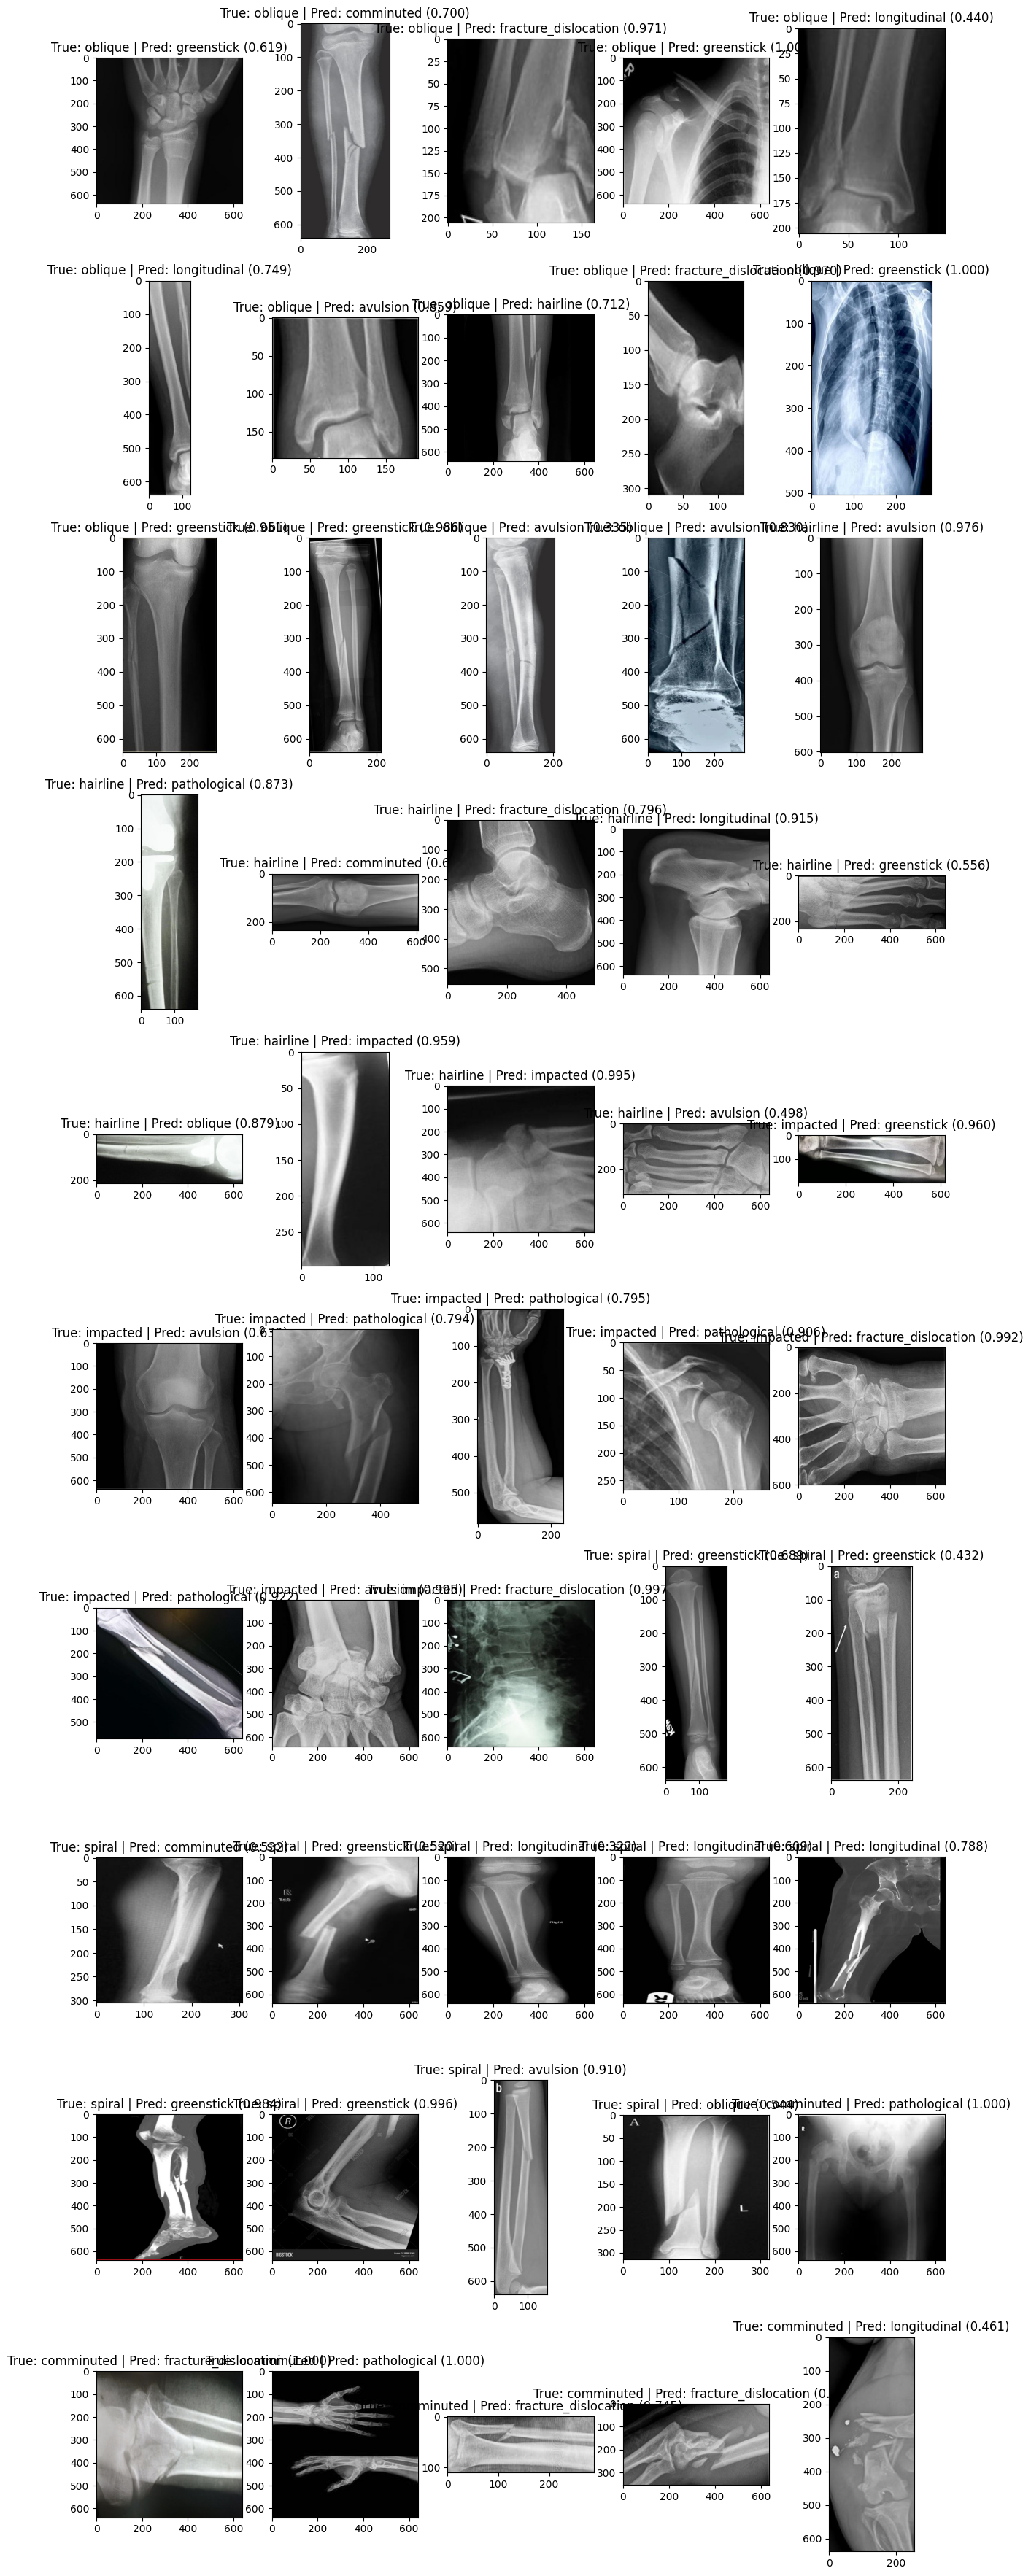

In [53]:
fig, axes = plt.subplots(10, 5, figsize=(15, 45))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_diff.full_path.iloc[i]))
    ax.set_title(f'True: {df_diff.target.iloc[i]} | Pred: {df_diff.predicted_class.iloc[i]} ({df_diff.predicted_class_proba.iloc[i]:.3f})')